In [1]:
import json

In [2]:
with open('/Users/kanhagannu/Desktop/Yuvi_RIP.json') as f:
    data = json.load(f)

In [3]:
len(data)

9189

In [4]:
y_tag = []
r_tag = []
yr_tag = []

In [5]:
for i in range(len(data)):
    if len(data[i]['entities']['hashtags'])==1:
        if data[i]['entities']['hashtags'][0]['text']=='MissYouYuvi':
            y_tag.append(data[i]['full_text'])

In [6]:
for i in range(len(data)):
    if len(data[i]['entities']['hashtags'])==1:
        if data[i]['entities']['hashtags'][0]['text']=='RestInPeace':
            r_tag.append(data[i]['full_text'])

In [7]:
for i in range(len(data)):
    if len(data[i]['entities']['hashtags'])==2:
        if (data[i]['entities']['hashtags'][0]['text']==('RestInPeace' or 'MissYouYuvi'))and(data[i]['entities']['hashtags'][1]['text']==('RestInPeace' or 'MissYouYuvi')):
            yr_tag.append(data[i]['full_text'])


In [8]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [9]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [10]:
data = [re.sub('\s+', ' ', sent) for sent in r_tag]
data = [re.sub("\'", "", sent) for sent in data]

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [12]:
data_words = list(sent_to_words(data))

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases. 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [30]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= 9, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [31]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.066*"https" + 0.066*"restinpeace" + 0.044*"co" + 0.034*"thank" + '
  '0.023*"family" + 0.023*"search" + 0.023*"later" + 0.023*"lyric" + '
  '0.012*"time" + 0.012*"condolence"'),
 (1,
  '0.052*"restinpeace" + 0.049*"read" + 0.038*"see" + 0.033*"first" + '
  '0.033*"open" + 0.033*"ok" + 0.033*"ama_joke" + 0.033*"hashtag" + '
  '0.023*"want" + 0.020*"co"'),
 (2,
  '0.045*"leader" + 0.032*"co" + 0.030*"https" + 0.024*"fe" + 0.024*"ehtjr" + '
  '0.023*"ore" + 0.023*"first" + 0.023*"raid" + 0.023*"succumb" + '
  '0.023*"time"'),
 (3,
  '0.057*"restinpeace" + 0.039*"can" + 0.020*"bad" + 0.020*"reason" + '
  '0.020*"go" + 0.020*"give" + 0.020*"strengt" + 0.020*"year" + '
  '0.020*"believe" + 0.020*"serve"'),
 (4,
  '0.133*"https" + 0.105*"restinpeace" + 0.071*"co" + 0.059*"dhak" + '
  '0.037*"trend" + 0.035*"see" + 0.030*"aise" + 0.030*"main" + 0.022*"soon" + '
  '0.022*"covid"'),
 (5,
  '0.049*"black" + 0.049*"body" + 0.048*"tortured" + 0.048*"could" + '
  '0.048*"kill" + 0.048*"com

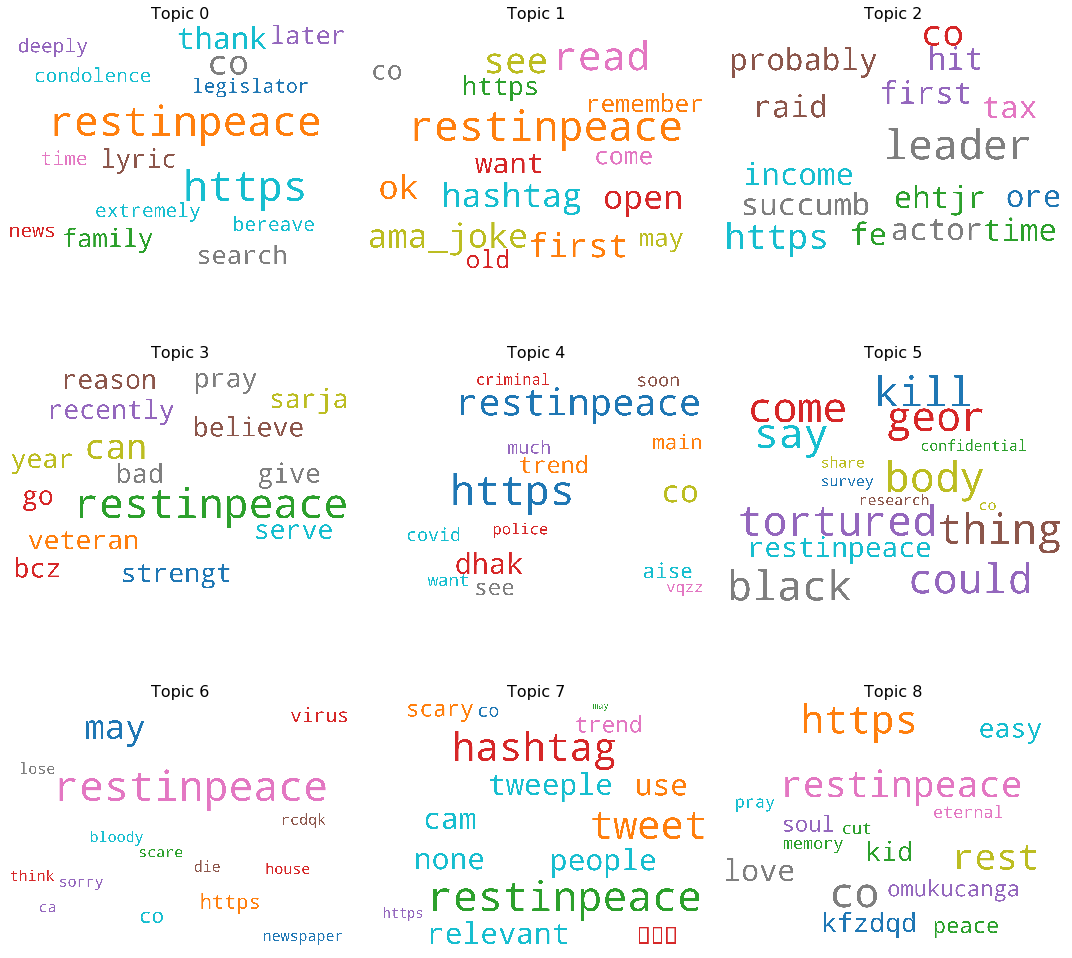

In [32]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  #color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False,num_topics=9,num_words=15)

fig, axes = plt.subplots(3,3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis